<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Vamos-testar-um-ambiente-simples,-com-5-distribuições-diferentes-de-y" data-toc-modified-id="Vamos-testar-um-ambiente-simples,-com-5-distribuições-diferentes-de-y-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Vamos testar um ambiente simples, com 5 distribuições diferentes de y</a></span></li><li><span><a href="#Criar-classe-do-modelo" data-toc-modified-id="Criar-classe-do-modelo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Criar classe do modelo</a></span></li><li><span><a href="#Treinar-por-100-epochs" data-toc-modified-id="Treinar-por-100-epochs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Treinar por 100 epochs</a></span></li><li><span><a href="#Avaliar-evolução-dos-parâmetros" data-toc-modified-id="Avaliar-evolução-dos-parâmetros-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Avaliar evolução dos parâmetros</a></span></li></ul></div>

In [1]:
import sys
import torch
import numpy as np  

from tqdm.notebook import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable

import matplotlib.pyplot as plt

# Vamos testar um ambiente simples, com 5 distribuições diferentes de y

In [2]:
Y = []

true_lambdas = []
for _ in range(5):
    lambda_ = np.random.exponential(5)
    true_lambdas.append(lambda_)
    Y.append(np.random.poisson(lambda_,size=20))

# Criar classe do modelo

In [11]:
class ModelWithNoRegressors(nn.Module):
    def __init__(self,n,a,eps=1e-2):
        super(ModelWithNoRegressors, self).__init__()
        
        self.alpha = a
        self.eps = eps
        
        self.linear1   = nn.Linear(1, n, bias=False)
        self.optimizer = optim.SGD(self.parameters(), lr=1)
        
        self.linear1.weight.data.fill_(eps)
        
        self.params_hist = []

    def forward(self,state=np.ones(1)):
        x = self.linear1(torch.from_numpy(state).float())
        x = F.relu(x) + self.eps
        return x
    
    def backward(self,Y,lambdas):
        
        self.params_hist.append(self.forward().detach().numpy())
           
        Z = torch.zeros(len(Y))
        Y = torch.tensor(Y) 
        
        gradients = []
        for iY,l,z in zip(Y,lambdas,Z):
            g = []
            for y in iY:
                
                verossimilhanca = l - y*torch.log(l)
                
                regularizador = []
                for il in lambdas:
                    regularizador.append(F.mse_loss(l,il) * self.alpha)
                regularizador = torch.stack(regularizador).sum()
                
                g.append(verossimilhanca + regularizador)
            gradients.append(torch.stack(g).sum())
            
        self.optimizer.zero_grad()
        grad = torch.stack(gradients).sum()
        grad.backward()
        self.optimizer.step()

In [12]:
model = ModelWithNoRegressors(5,0)

# Treinar por 100 epochs

In [9]:
for i in tqdm(range(1000)):
    lambdas = model.forward()
    model.backward(Y,lambdas)

# Avaliar evolução dos parâmetros

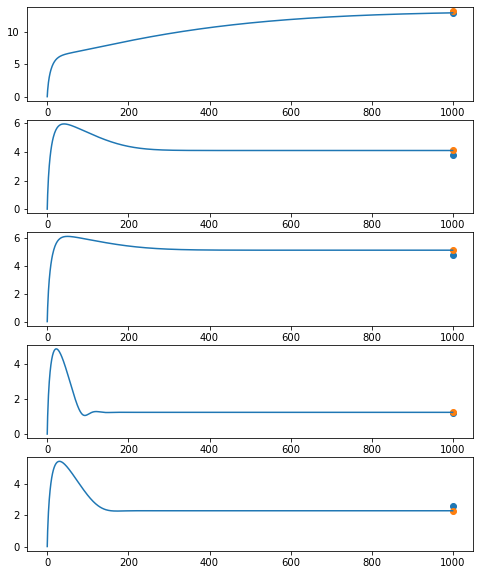

In [10]:
fig,axes = plt.subplots(nrows=len(Y),ncols=1,figsize=(8,10))

for i,p in enumerate(np.array(model.params_hist).transpose()):
    orig_lambda = true_lambdas[i]
    real_mean   = np.mean(Y,1)[i]
    
    axes[i].plot(p)
    axes[i].scatter([len(p)],[orig_lambda])
    axes[i].scatter([len(p)],[real_mean])